**Things I've tried**

- Image size (160,160,3) with EfficientNetB4, learning rate 0.001 accuracy got stuck in local minimum of 0.6148.
- Image size (512,512,3) with EfficientNetB4, learning rate 0.001 accuracy got stuck in local minimum of 0.6148.
- Image size (512,512,3) with EfficientNetB4, learning rate 0.0002 accuracy got stuck in local minimum of 0.6137.
- Image size (512,512,3) with EfficientNetB4, learning rate 0.0002, label smoothing 0.1, accuracy got stuck in local minimum of 0.6137.

[Jump to fitting](#Fitting)

In [1]:
import json
import os

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, Input, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
# learning rate decay scheduler
from tensorflow.keras.experimental import CosineDecay

from tensorflow.keras.applications import efficientnet

In [2]:
tf.__version__

'2.3.1'

All the configurations required for training the model

In [3]:
#TPU Configurations
AUTO = tf.data.experimental.AUTOTUNE

# other configurations
class configurations():
    def __init__(self, IMG_SIZE, EPOCHS, BATCH_SIZE, DROPOUT_RATE, INIT_LEARNING_RATE, ALPHA):
        '''
        :param IMG_SIZE: a tuple of length 2 that defines the height and width of the image
        :param EPOCHS: no. of epochs to train the neural network
        :param BATCH_SIZE: size of a batch of images
        :param DROPOUT_RATE: the ratio of nodes to remove randomly during training
        :param INIT_LEARNING_RATE: initial learning rate for gradient descent
        :param ALPHA: parameter required for CosineDecay learning rate scheduler
        '''
        self.IMG_SIZE = IMG_SIZE
        self.INPUT_SHAPE = IMG_SIZE + (3,)
        self.EPOCHS = EPOCHS
        self.BATCH_SIZE = BATCH_SIZE
        self.DROPOUT_RATE = DROPOUT_RATE
        self.INIT_LEARNING_RATE = INIT_LEARNING_RATE
        self.ALPHA = ALPHA
        
    def __str__(self):
        return str(self.__dict__)
        
config = configurations(IMG_SIZE = (512,512),
                        EPOCHS=8,
                        BATCH_SIZE = 32,
                        DROPOUT_RATE = 0.4,
                        INIT_LEARNING_RATE = 1e-4,
                        ALPHA=0.3)

print(config)

{'IMG_SIZE': (512, 512), 'INPUT_SHAPE': (512, 512, 3), 'EPOCHS': 8, 'BATCH_SIZE': 32, 'DROPOUT_RATE': 0.4, 'INIT_LEARNING_RATE': 0.0001, 'ALPHA': 0.3}


In [4]:
BASE_DIR = "/kaggle/input/cassava-leaf-disease-classification/"

In [5]:
with open(os.path.join(BASE_DIR, "label_num_to_disease_map.json")) as file:
    map_classes = json.loads(file.read())
    map_classes = {int(k) : v for k, v in map_classes.items()}
    
map_classes

{0: 'Cassava Bacterial Blight (CBB)',
 1: 'Cassava Brown Streak Disease (CBSD)',
 2: 'Cassava Green Mottle (CGM)',
 3: 'Cassava Mosaic Disease (CMD)',
 4: 'Healthy'}

In [6]:
image_file_to_label_df = pd.read_csv(os.path.join(BASE_DIR, "train.csv"))

print(image_file_to_label_df.shape)
print("-"*50)
image_file_to_label_df.head()

(21397, 2)
--------------------------------------------------


,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [7]:
# split into train test sets
X_train, X_val, y_train, y_val = train_test_split(list(image_file_to_label_df.image_id),
                                                  list(image_file_to_label_df.label),
                                                  test_size=0.2)

In [8]:
# appending the base directory to all images' filename
X_train = [os.path.join(os.path.join(BASE_DIR, "train_images"), filename) for filename in X_train]
X_val = [os.path.join(os.path.join(BASE_DIR, "train_images"), filename) for filename in X_val]

In [9]:
(len(X_train), len(y_train)), (len(X_val), len(y_val))

((17117, 17117), (4280, 4280))

In [10]:
# turn the labels to categorical
y_train = tf.one_hot(indices=y_train, depth=5)
y_val = tf.one_hot(indices=y_val, depth=5)

**Some functions to preprocess the image**

In [11]:
def parse_function(filename, label, image_size=config.IMG_SIZE):
    '''
    Processes the image stored at `filename`. Decode and convert the image to float type, resize it.
    
    :param filename: filepath to the image
    :param label: the label of the image, should be a one-hot vector of length 5
    :param image_size: the desired image size, should be an iterable with 2 elements
    :return resized_image: resized version of the image from the `filename`
    :return label: label of the image
    '''
    image_string = tf.io.read_file(filename)

    #Don't use tf.image.decode_image, or the output shape will be undefined
    image = tf.image.decode_jpeg(image_string, channels=3)

    #This will convert to float values in [0, 1]
    image = tf.image.convert_image_dtype(image, tf.float32)

    resized_image = tf.image.resize(image, image_size)
    
    return resized_image, label

def data_augmentation(image, label):
    '''
    Data augmentation an image for training
    
    :param image: an image, should be an output from parse_function(...)
    :param label: the label of image
    '''
    
    # flips the image laterally at random
    image = tf.image.random_flip_left_right(image)
    
    # randomly adjusts the brightness of the image
    image = tf.image.random_brightness(image, max_delta=32.0 / 255.0)
    
    # randomly adjusts the saturation of the image
    image = tf.image.random_saturation(image, lower=0.5, upper=1.5)

    #Make sure all the elements in the image is still in [0, 1]
    image = tf.clip_by_value(image, 0.0, 1.0)

    return image, label

In [12]:
# process dataset for training
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(len(X_train))
train_dataset = train_dataset.map(parse_function, num_parallel_calls=4)
train_dataset = train_dataset.map(data_augmentation, num_parallel_calls=4)
train_dataset = train_dataset.batch(config.BATCH_SIZE)
train_dataset = train_dataset.prefetch(1)

In [13]:
# process dataset for validation
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.shuffle(len(X_val))
val_dataset = val_dataset.map(parse_function, num_parallel_calls=4)
val_dataset = val_dataset.batch(config.BATCH_SIZE)
val_dataset = val_dataset.prefetch(1)

**Training**

In [14]:
weight_filepath = '../input/tfkerasefficientnetimagenetnotop/efficientnetb4_notop.h5'
# weight_filepath = '../Model weights/efficient_net/efficientnetb4_notop.h5'

base_model = efficientnet.EfficientNetB4(weights=weight_filepath, 
                                         include_top=False,
                                         input_shape=config.INPUT_SHAPE)

In [15]:
model = Sequential(name="cassava-leaf-disease-net")
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(rate=config.DROPOUT_RATE))
model.add(Dense(5, activation="softmax"))

base_model.trainable = False

In [16]:
model.summary()

Model: "cassava-leaf-disease-net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb4 (Functional)  (None, 16, 16, 1792)      17673823  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1792)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1792)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 8965      
Total params: 17,682,788
Trainable params: 8,965
Non-trainable params: 17,673,823
_________________________________________________________________


In [17]:
def label_smoothing(y_true,y_pred):
    
     return tf.keras.losses.categorical_crossentropy(y_true,y_pred,label_smoothing=0.1)

In [18]:
DECAY_STEPS = int(round(len(X_train)/config.BATCH_SIZE))*config.EPOCHS
cosine_decay = CosineDecay(initial_learning_rate=config.INIT_LEARNING_RATE, decay_steps=DECAY_STEPS, alpha=config.ALPHA)

In [19]:
# compile the model
model.compile(optimizer = Adam(cosine_decay),
              loss = label_smoothing,
              metrics = ['accuracy'])

## Fitting

In [20]:
history = model.fit(train_dataset,
                    epochs=config.EPOCHS,
                    verbose=1,
                    validation_data=val_dataset
                   )

Epoch 1/8
535/535 [==============================] - 318s 594ms/step - loss: 1.2859 - accuracy: 0.6130 - val_loss: 1.2596 - val_accuracy: 0.6178
Epoch 2/8
535/535 [==============================] - 307s 574ms/step - loss: 1.2820 - accuracy: 0.6142 - val_loss: 1.2602 - val_accuracy: 0.6178
Epoch 3/8
535/535 [==============================] - 304s 568ms/step - loss: 1.2782 - accuracy: 0.6142 - val_loss: 1.2611 - val_accuracy: 0.6178
Epoch 4/8
535/535 [==============================] - 306s 572ms/step - loss: 1.2797 - accuracy: 0.6142 - val_loss: 1.2597 - val_accuracy: 0.6178
Epoch 5/8
535/535 [==============================] - 305s 570ms/step - loss: 1.2782 - accuracy: 0.6142 - val_loss: 1.2589 - val_accuracy: 0.6178
Epoch 6/8
535/535 [==============================] - 305s 570ms/step - loss: 1.2762 - accuracy: 0.6142 - val_loss: 1.2583 - val_accuracy: 0.6178
Epoch 7/8
535/535 [==============================] - 305s 571ms/step - loss: 1.2786 - accuracy: 0.6142 - val_loss: 1.2586 - val_ac

In [21]:
history_df = pd.DataFrame(history.history)
history_df.head()

,loss,accuracy,val_loss,val_accuracy
0,1.285920,0.612958,1.259575,0.617757
1,1.282050,0.614243,1.260177,0.617757
2,1.278237,0.614243,1.261122,0.617757
3,1.279699,0.614243,1.259684,0.617757
4,1.278177,0.614243,1.258850,0.617757


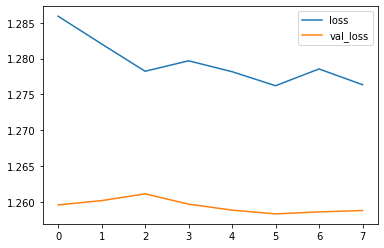

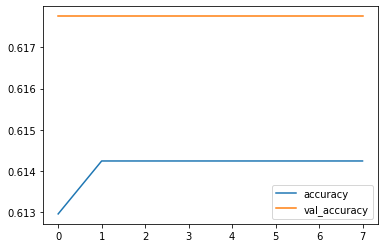

In [22]:
history_df[['loss', 'val_loss']].plot()
history_df[['accuracy', 'val_accuracy']].plot()

In [23]:
pred = model.predict(val_dataset, verbose=1)

134/134 [==============================] - 58s 432ms/step


In [26]:
# saving my model
model.save("efficientnetv4_imgsize_512_22122020_12_57_model.h5")

In [24]:
def val_accuracy(pred, y_val):
    return sum(np.apply_along_axis(np.argmax, 1, pred) == np.apply_along_axis(np.argmax, 1, y_val)) / len(pred)

In [25]:
val_accuracy(pred, y_val)

0.6177570093457944

**Predictions**

In [ ]:
# Test image folder directory
TEST_DIR = '../input/cassava-leaf-disease-classification/test_images/'

In [ ]:
X_test = [TEST_DIR + image for image in os.listdir(TEST_DIR)]

In [ ]:
def parse_function_test(filename, image_size=IMG_SIZE):
    '''
    Processes the image stored at filename
    
    :param filename: filepath to the image
    :param label: the label of the image, should be a one-hot vector of length 5
    :param image_size: the desired image size, should be an iterable with 2 elements
    :return resized_image: resized version of the image from the `filename`
    :return label: label of the image
    '''
    image_string = tf.io.read_file(filename)

    #Don't use tf.image.decode_image, or the output shape will be undefined
    image = tf.image.decode_jpeg(image_string, channels=3)

    #This will convert to float values in [0, 1]
    image = tf.image.convert_image_dtype(image, tf.float32)

    resized_image = tf.image.resize(image, image_size)
    
    return resized_image

def test_preprocess(image):
    '''
    :param image: an image, should be an output from parse_function(...)
    :param label: the label of image
    '''
    
    # flips the image laterally at random
    image = tf.image.random_flip_left_right(image)
    
    # randomly adjusts the brightness of the image
    image = tf.image.random_brightness(image, max_delta=32.0 / 255.0)
    
    # randomly adjusts the saturation of the image
    image = tf.image.random_saturation(image, lower=0.5, upper=1.5)

    #Make sure all the elements in the image is still in [0, 1]
    image = tf.clip_by_value(image, 0.0, 1.0)

    return image

In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices((X_test))
test_dataset = test_dataset.shuffle(len(X_test))
test_dataset = test_dataset.map(parse_function_test, num_parallel_calls=4)

for image in test_dataset.take(1):
    show(image, label=np.array([1,0,0,0,0]))

test_dataset = test_dataset.map(test_preprocess, num_parallel_calls=4)

for image in test_dataset.take(1):
    show(image, label=np.array([1,0,0,0,0]))

test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.prefetch(1)

In [ ]:
pred = model.predict(test_dataset, verbose=1)

In [ ]:
#Creating submission file

sub = pd.DataFrame({'image_id': os.listdir(TEST_DIR), 'label': list(np.apply_along_axis(np.argmax, 1, pred))})
print(sub)
sub.to_csv('submission.csv', index = False)